# REINFORCE algorithm

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.agents.reinforce.reinforce_agent import ReinforceAgent
from tf_agents.utils import common as cmn

import matplotlib.pyplot as plt
import qutip
from qutip import sigmap, expect

import random

import sys
sys.path.append('../')
from common.common import get_average_return, extract_single_action_policy

%matplotlib inline

2024-03-11 22:54:57.453468: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 22:54:57.479731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 22:54:57.479754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 22:54:57.480717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 22:54:57.484995: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 22:54:57.485509: I tensorflow/core/platform/cpu_feature_guard.cc:1

* System parameters

In [2]:
T = 5 # terminal time step
max_steps = 15 # number of time steps

* Create training and evaluation environments and define actions

In [3]:
# validate environment
from environments.qubit_env import QubitEnv

# define actions
# TODO: actions can be continuous within a range of course 
# actions will be the change in the magnetic field
max_Ω = 1

nb_actions = 9
zero_action = np.array(0, dtype = np.float32) # action 0
plus_action = np.array(max_Ω, dtype = np.float32) # action 1
minus_action = np.array(-max_Ω, dtype = np.float32) # action 2
half_plus_action = np.array(max_Ω / 2, dtype = np.float32) # action 3
half_minus_action = np.array(-max_Ω / 2, dtype = np.float32) # action 5
quarter_plus_action = np.array(max_Ω / 4, dtype = np.float32) # action 6
quarter_minus_action = np.array(-max_Ω / 4, dtype = np.float32) # action 7
plus2_action = np.array(2 * max_Ω, dtype = np.float32) # action 8
minus2_action = np.array(-2 * max_Ω, dtype = np.float32) # action 9

actions = [quarter_plus_action, quarter_minus_action, half_plus_action, half_minus_action, zero_action, plus_action, minus_action, plus2_action, minus2_action]

# shuffle them randomly to avoid bias
random.shuffle(actions)
seed = 1989
tf.random.set_seed(seed)
omegas = [-max_Ω, -3 * max_Ω / 4, -max_Ω / 4, -max_Ω / 2, 0, max_Ω / 2, max_Ω / 4, 3 * max_Ω / 4, max_Ω]

environment = QubitEnv(T, max_steps, max_Ω, actions, fidelity_threshold = 0.99, verbose_fg = False, nb_actions = nb_actions, seed = seed)
eval_environment = QubitEnv(T, max_steps, max_Ω, actions, fidelity_threshold = 0.99, verbose_fg = False, nb_actions = nb_actions, seed = seed)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

In [4]:
fc_layer_params = (100, 75)
learning_rate = 1e-3
replay_buffer_capacity = 10000
num_iterations = 2000
nb_episodes = 1
eval_interval = 10

In [5]:
actor_network = actor_distribution_network.ActorDistributionNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    name = "Policy"
)

# use tha Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

value_net = value_network.ValueNetwork(
    input_tensor_spec = train_env.observation_spec(),
    fc_layer_params = (100, 75),
    name = 'ValueNet'
) 

agent = ReinforceAgent(
    time_step_spec = environment.time_step_spec(),
    action_spec = environment.action_spec(),
    actor_network = actor_network,
    value_network = value_net,
    optimizer = optimizer,
    normalize_returns = True,
    train_step_counter = train_step_counter,
    gamma = 0.99
)

agent.initialize()

2024-03-11 22:54:59.520351: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dkoytrom-pc
2024-03-11 22:54:59.520366: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dkoytrom-pc
2024-03-11 22:54:59.520442: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-03-11 22:54:59.520464: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.54.14


In [6]:
# collect trajectories
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = None,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = cmn.function(agent.train)

# Reset the train step.
# agent.train_step_counter.assign(0)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function = True),
    observers = [rb_observer],
    max_episodes = nb_episodes
)

# create checkpointer to load training and continue
""" checkpointer = common.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp90j59h2w.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmp90j59h2w
[reverb/cc/platform/default/server.cc:71] Started replay server on port 33067


' checkpointer = common.Checkpointer(\n    ckpt_dir = checkpoint_dir,\n    max_to_keep = 1,\n    agent = agent,\n    policy = agent.policy,\n    replay_buffer = replay_buffer,\n)\n\ncheckpointer.initialize_or_restore() '

In [7]:
avg_returns = [get_average_return(eval_env, agent.policy, 10)]

for _ in range(num_iterations):
    initial_time_step = environment.reset()
    collect_driver.run(initial_time_step)

    # create dataset from trajectories
    dataset = replay_buffer.as_dataset(sample_batch_size = 1)
    iterator = iter(dataset)

    trajectories , _ = next(iterator)

    # train 
    train_loss = agent.train(experience = trajectories)

    replay_buffer.clear()

    step = agent.train_step_counter.numpy()

    if step % 50 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = get_average_return(eval_env, agent.policy, 10)
        avg_returns.append(avg_return)


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.


step = 50: loss = 5.9874091148376465


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.


step = 100: loss = 41.16783142089844


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.


step = 150: loss = 59.480224609375
step = 200: loss = 3.5602176189422607
step = 250: loss = 177.59573364257812


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.


step = 300: loss = 123.09845733642578
step = 350: loss = 54.398075103759766
step = 400: loss = 43.65087127685547
step = 450: loss = 17.196453094482422
step = 500: loss = 16.020267486572266


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.


step = 550: loss = 11.613960266113281
step = 600: loss = 9.969215393066406
step = 650: loss = 6.207477569580078
step = 700: loss = 12.69680404663086
step = 750: loss = 2.824014902114868
step = 800: loss = 7.291779518127441
step = 850: loss = 1.2328327894210815
step = 900: loss = 2.631471633911133
step = 950: loss = 1.7879271507263184
step = 1000: loss = 1.1276323795318604


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (555412) so Table uniform_table is accessed directly without gRPC.


step = 1050: loss = 0.6150857210159302
step = 1100: loss = 0.3444158732891083
step = 1150: loss = 0.9211223125457764
step = 1200: loss = 0.18710920214653015
step = 1250: loss = 0.2153562307357788
step = 1300: loss = 0.16485923528671265
step = 1350: loss = 0.12578800320625305
step = 1400: loss = 0.12196441739797592
step = 1450: loss = 0.10938571393489838
step = 1500: loss = 0.10770593583583832
step = 1550: loss = 1.3018362522125244
step = 1600: loss = 0.11586736142635345
step = 1650: loss = 0.12700419127941132
step = 1700: loss = 0.13962657749652863
step = 1750: loss = 0.18423853814601898
step = 1800: loss = 0.16103023290634155
step = 1850: loss = 0.8363012075424194
step = 1900: loss = 0.12309198081493378
step = 1950: loss = 0.13285326957702637
step = 2000: loss = 0.11627860367298126


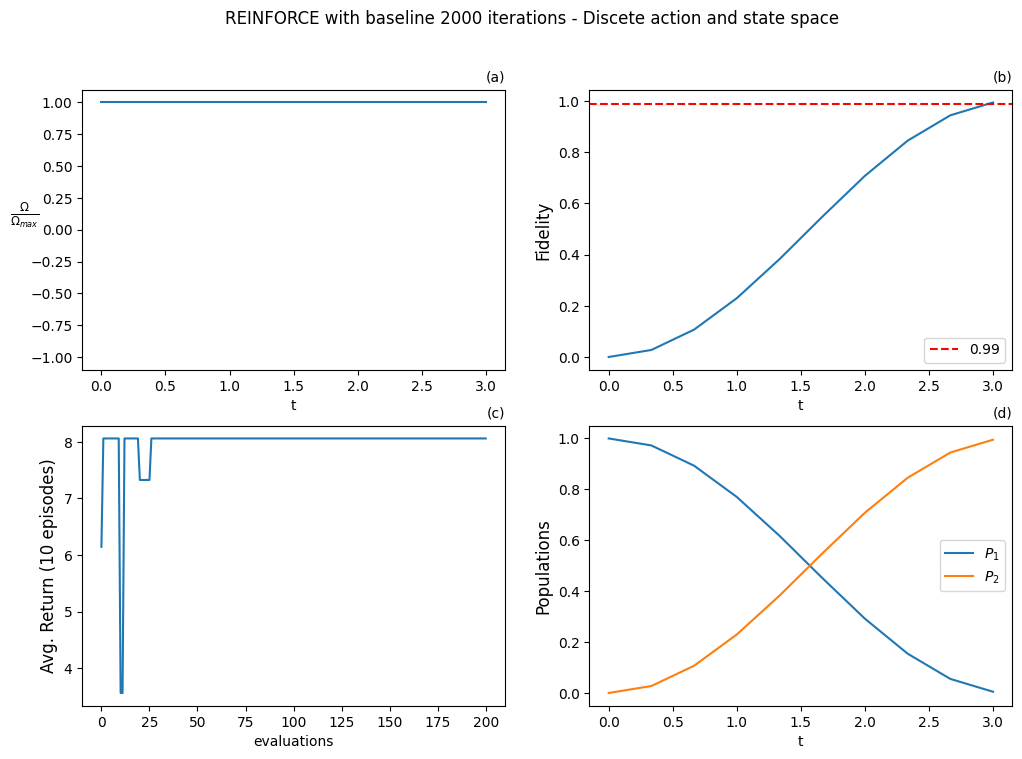

In [8]:
greedy_actions, optimal_omegas, states, fidelities = extract_single_action_policy(environment, agent)

population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

time_span = np.arange(len(optimal_omegas))
time_span = [t * T / max_steps for t in time_span]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f'REINFORCE with baseline {num_iterations} iterations - Discete action and state space')

ax1.step(time_span, optimal_omegas, where = 'post')
ax1.set_ylabel(r"$\frac{\Omega}{\Omega_{max}}$", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlabel(f"t")
ax1.set_title("(a)", loc = "right", fontsize = 10)

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.99, color = 'r', linestyle = '--', label = '0.99')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"t")
ax2.legend(loc = 'lower right')
ax2.set_title("(b)", loc = "right", fontsize = 10)

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(f"t")
ax4.set_title("(d)", loc = "right", fontsize = 10)
ax4.legend()

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Avg. Return (10 episodes)", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
ax3.set_title("(c)", loc = "right", fontsize = 10)

plt.show()